In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import svm
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer


import nltk
from nltk.tokenize import word_tokenize

In [2]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/mohammed/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/mohammed/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
from sklearn.feature_extraction.text import CountVectorizer

In [30]:
def load_data(data_label):
    """Return a DataFrame with two columns, named 'text'
    and 'target'. Column 'sentiment', an integer between 0 and 5,
    is a numerical representation of the sentiment in Column 'text'.
    
    params:
    ----------------------
        data_label: "tweets" or "movies".
            We can add other datasets if needed.
    """
    
    
    if data_label == "tweets":
        return pd.read_csv('../datasets/200-thousand-tweets.csv',
                           encoding='latin-1',
                           header = None,
                           usecols=[0, 5],
                           names=["sentiment", "text"])
    elif data_label == "movies":
        return pd.read_csv('../datasets/8.5-thousand-reviews.tsv',
                           sep='\t',
                           header = None,
                           usecols=[0, 1],
                           names=["sentiment", "text"])
     
    raise ValueError("Invalid `data_label` used. Currently supported options are "
        "\"tweets\" and \"movies\".")
        
data = load_data("tweets")

In [39]:
training_count = 5000
test_count = 1000
total_count = training_count + test_count

# How many numerical features to construct out of a given text.
# The mathematical modelling will be based on these numerical features,
# rather than the text itself.
features_count = 300

# Random sample
data = data.sample(n=total_count, random_state=100).reset_index(drop=True)

In [40]:
def clean_text(text):
    """
    Return clean text
    params
    ------------
        text: string
    """

    text = text.lower() # Lowercase
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if not t in stopwords] # Remove stopwords
    tokens = [t for t in tokens if t.isalnum()] # Remove punctuation
    text_clean = " ".join(tokens)
    
    return text_clean

# Clean text 
data['text'] = [clean_text(text) for text in data['text']]

In [41]:
data.head()

,sentiment,text
0,4,miggg jealous cause get covers time skeezah haha
1,4,zarg lol definitely truism
2,4,kathrynjay til sunday absolutely zilch lol alt...
3,4,kyranbracken skate school looks fantastic grea...
4,4,chillin work three days week


In [42]:
# Train test split
train = data[:training_count]
test = data[training_count:total_count].reset_index(drop=True)

# Create count vectoriser 
vectorizer = CountVectorizer(ngram_range=(1, 2),
                             max_features=features_count)

# Transform training corpus into feature matrix
X = vectorizer.fit_transform(train["text"])
feature_names = vectorizer.get_feature_names()

x_train = pd.DataFrame(data=X.toarray(), columns=feature_names)
y_train = train["sentiment"]

In [43]:
# Transform testing corpus into feature matrix
X = vectorizer.transform(test['text'])

x_test = pd.DataFrame(data=X.toarray(),columns=feature_names)
y_test = test['sentiment']

In [44]:
# Min-Max scalling
x_max = x_train.max()
x_min = x_train.min()

x_train = (x_train-x_min) / x_max
x_test = (x_test-x_min) / x_max

In [45]:
# Fit SVM
model = svm.SVC(kernel='linear', C=1).fit(x_train, y_train)

# Get predictions on test set
y_pred = model.predict(x_test)

# Accuracy on test set
accuracy = accuracy_score(y_test,y_pred)
print("Accuracy: {}".format(accuracy))

Accuracy: 0.702


Text(0.5, 61.5, 'Predicted')

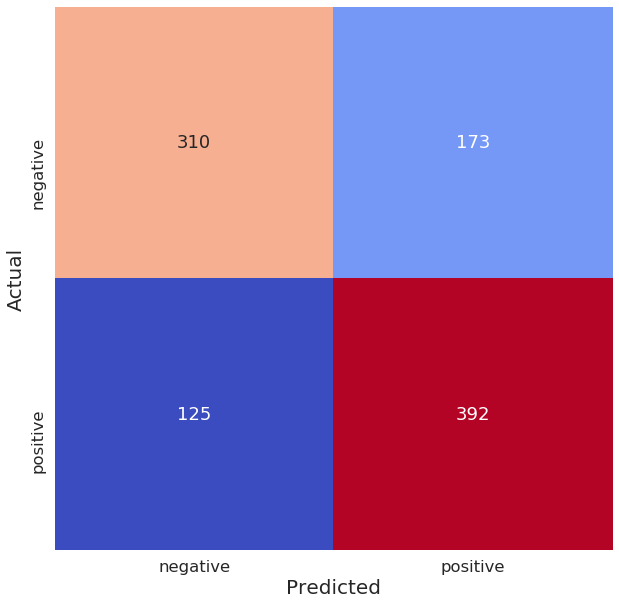

In [46]:
# Create confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix = pd.DataFrame(data=conf_matrix,
                           columns=['negative', 'positive'],
                           index=['negative', 'positive'])

# Plot confusion matrix
plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
sns.set(font_scale=1.5)
sns.heatmap(conf_matrix, cmap='coolwarm', annot=True, fmt='.5g', cbar=False)
plt.ylabel('Actual', size=20)
plt.xlabel('Predicted', size=20)